In [1]:
import hdf5storage
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from analysis_util import *

import seaborn as sns
import jedi

# sklearn packages 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn import metrics

'''this script concate each block per subject to a file wihthin subject called s103_df_concat.csv'''

'''subsequently save a concatenante file under rechain-beh called all_df_concat.csv '''


# global setting f
plt.rcParams.update({"font.size": 18})
sns.set_palette("Set2")
sns.set(style="whitegrid")


In [2]:


PROJECT_DIR = "/data/rwchain-all/round2"
BEH_DIR = os.path.join(PROJECT_DIR, "rwchain-beh/data")
EEG_DIR = os.path.join(PROJECT_DIR, "rwchain-eeg")
ALL_BEH_DIR = os.path.join(PROJECT_DIR, 'rwchain-beh', 'combined')



In [3]:
CODE_DIR = "/home/jenny/evidence-chain/"
FIG_DIR = os.path.join(CODE_DIR, "figs/descriptive/")

In [14]:
list_of_subj = os.listdir(BEH_DIR)
list_of_subj.sort()
# list_of_subj = [list_of_subj[5]]

df = pd.read_pickle(os.path.join(ALL_BEH_DIR, 'all_df_concat.pkl'))
# organize some columsn
 
df['key'][df['key'] == '[5]'] = 1
df['key'][df['key'] == '[3]'] = 1
df['key'][df['key'] == '[2]'] = 0
df['cumsum'] = df['sequence_clean'].apply(lambda x: [sum(x[:i+1]) for i in range(len(x))])

# get rid of a ;pw acc subject
df = df[df['sid']!='s108']

# df = df[df['count'] >=3]
# df = df[df['stimDur'] != 0.5]
# df = df[df['stimDur'] != 0.05]



/tmp/ipykernel_117298/4214647947.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[5]'] = 1
/tmp/ipykernel_117298/4214647947.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[3]'] = 1
/tmp/ipykernel_117298/4214647947.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['key'][df['key'] == '[2]'] = 0


In [15]:
df = correct_samples_by_condition(df)

In [16]:
cumsum = np.array(df['cumsum'].to_list())
sequence =  np.array(df['sequence_clean'].to_list())
count = df['count_corrected'].to_numpy()

In [17]:
df.head()


,time,bytetime,press,count,key,stimDur,Bias,sequence,block,sequence_clean,sid,cumsum,count_corrected
0,2.6166679859161377,2611,[1],10,0,0.25,0.12,[-1. 1. -1. 1. -1. 1. -1. -1. -1. -1. -1. ...,0,"[-1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, ...",s102,"[-1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -2.0, ...",9
1,2.2499890327453613,2233,[1],8,1,0.25,0.12,[-1. -1. -1. 1. 1. 1. 1. 1. -1. -1. -1. -...,0,"[-1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1...",s102,"[-1.0, -2.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, ...",7
2,2.1333320140838623,2118,[1],8,0,0.25,0.12,[ 1. -1. -1. -1. 1. 1. -1. -1. -1. -1. 1. ...,0,"[1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, ...",s102,"[1.0, 0.0, -1.0, -2.0, -1.0, 0.0, -1.0, -2.0, ...",7
3,1.2833738327026367,1270,[1],5,1,0.25,0.12,[ 1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -...,0,"[1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1....",s102,"[1.0, 2.0, 3.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, ...",4
4,2.3333139419555664,2318,[1],9,1,0.25,0.12,[-1. 1. -1. 1. 1. -1. 1. 1. 1. -1. -1. -...,0,"[-1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1....",s102,"[-1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 3.0...",8


In [18]:
# create a matrix of +1 and -1 with NaNs if the chain terminates

chain_matrix = get_chain_matrix(sequence, count)


In [19]:

# # calculate terminated chains
# cumsum_stop_list = []

# for c in range(cumsum.shape[0]):
#     cumsum_stop = cumsum[
#         c, : int(count[c])
#     ]  # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
#     cumsum_stop_list.append(cumsum_stop)
 



In [20]:

# # Get unique subids
# unique_subids = df['sid'].unique()
# unique_stimDur = df['stimDur'].unique()
# # Create a figure for each unique subid
# for subid in unique_subids:
#     for stimdur in unique_stimDur:
#         fig, ax = plt.subplots(1,1,figsize=(10,7))
#         data = df[df['sid']==subid]
#         data = data[data['stimDur']==stimdur]
#         sns.countplot(df, x = data['count'], palette="Set2", ax = ax)
#         ax.set(xlabel = "Number of Samples at Termination")
#         fig.suptitle(f'{subid}, {stimdur}')
#         fig.show()
# # 

In [21]:
df['count_corrected'].max()

29

In [22]:
FIG_DIR

'/home/jenny/evidence-chain/figs/descriptive/'

/tmp/ipykernel_117298/3477367870.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


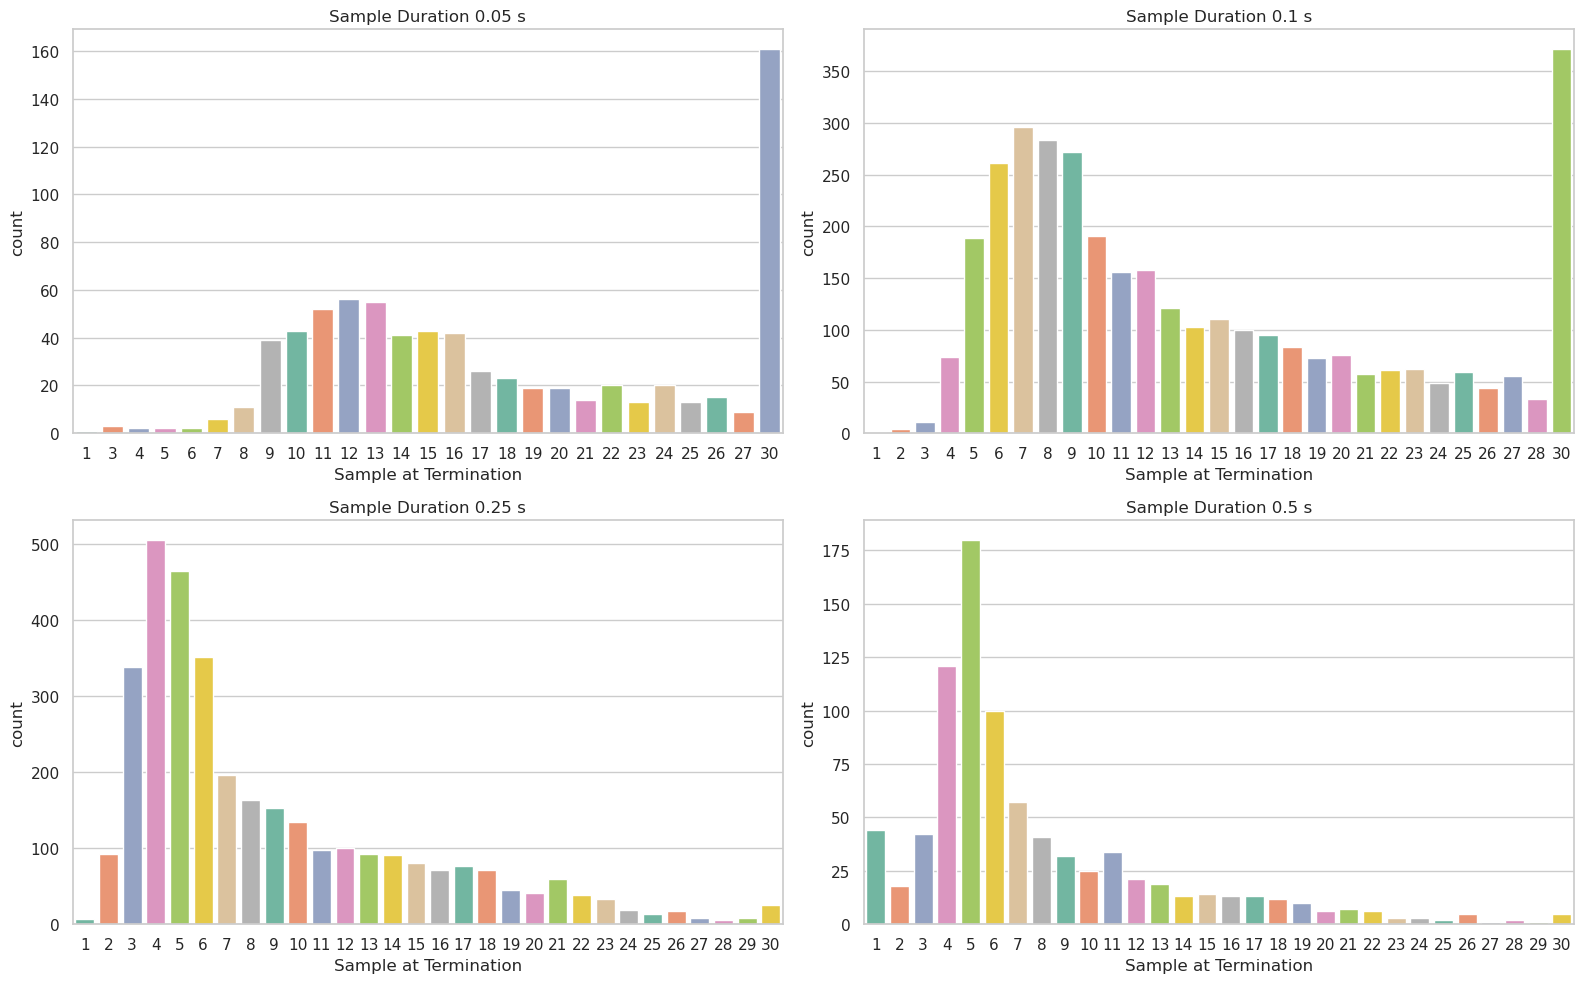

In [35]:
fig, ax = plt.subplots(2, 2, figsize = (16,10))
ax = ax.flatten()
# # Get unique subids
unique_subids = df['sid'].unique()
unique_stimDur = df['stimDur'].unique()
unique_stimDur.sort()
# Create a figure for each unique subid
for ind, stimdur in enumerate(unique_stimDur):
    data = df[df['stimDur']==stimdur]
    sns.countplot(df, x = data['count_corrected']+1, palette="Set2", ax = ax[ind])
    ax[ind].set(xlabel = "Sample at Termination")
    ax[ind].set_title(f'Sample Duration {stimdur} s')
fig.tight_layout()
fig.savefig(f'{FIG_DIR}sample_at_termination_hist_all.png', dpi=300)
fig.show()
# # 

/tmp/ipykernel_547235/994898605.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


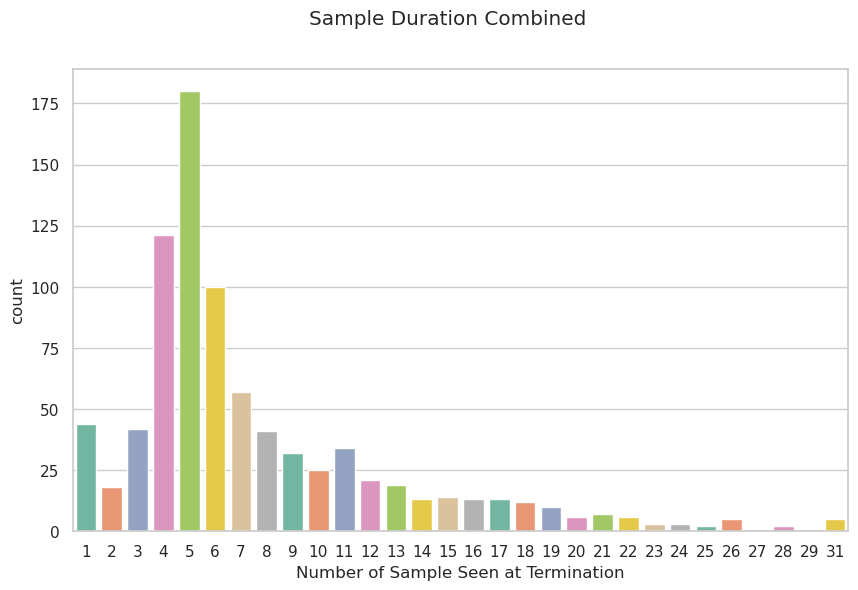

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(10,6))
data = df[df['stimDur']==stimdur]
sns.countplot(df, x = data['count']+1, palette="Set2", ax = ax)
ax.set(xlabel = "Number of Sample Seen at Termination")
fig.suptitle(f'Sample Duration Combined')
fig.show()